In [1]:
import sys   ###qmdp1（上の2つのセル）
sys.path.append('../scripts/')
from dynamic_programming import *
from dp_policy_agent import *

In [2]:
class QmdpAgent(DpPolicyAgent):
    def __init__(self, time_interval, pf, goal, puddles, sampling_num=10, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                 puddle_coef=100.0, lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T): 
        super().__init__(time_interval, pf, widths, lowerleft, upperright)
        self.in_goal = False
        self.dp = DynamicProgramming(widths, goal, puddles, time_interval, sampling_num)     #追加: dpのオブジェクトを持たせる
        self.dp.value_function = self.init_value()       #追加
        self.next_values = np.array([0.0, 0.0, 0.0]) #追加。描画用
        
        self.history = []

    def action_value(self, action, index): #追加。はみ出しペナルティーをゼロに
        value = 0.0
        for delta, prob in self.dp.state_transition_probs[(action, index[2])]: 
            after, _ = self.dp.edge_correction(np.array(index).T + delta)
            after = tuple(after)
            reward = - self.dp.time_interval * self.dp.depths[(after[0], after[1])] * self.dp.puddle_coef - self.dp.time_interval
            value += (self.dp.value_function[after] + reward) * prob

        return value

    def init_value(self): #追加
        tmp = np.zeros(self.dp.index_nums)
        for line in open("value.txt", "r"):
            d = line.split()
            tmp[int(d[0]), int(d[1]), int(d[2])] = float(d[3])
            
        return tmp
    
    def policy(self, pose):
        next_values = np.array([0.0, 0.0, 0.0])
        for p in self.estimator.particles:
            index = np.floor((p.pose - self.dp.pose_min)/self.dp.widths).astype(int) 
            index[2] = (index[2] + self.dp.index_nums[2]*1000)%self.dp.index_nums[2] #角度の正規化
            for i in [0,1]:   
                if index[i] < 0: index[i] = 0
                elif index[i] >= self.dp.index_nums[i]: index[i] = self.dp.index_nums[i] - 1
                    
            cur_value = self.dp.value_function[tuple(index)]
            next_values += (np.array([ self.action_value(a, index) for a in self.dp.actions ]) - cur_value)*p.weight#*(abs(cur_value)**6)

        self.next_values = next_values

        self.history.append(self.dp.actions[np.argmax(next_values)])
        
        if len(self.history) >= 2 and self.history[-1][0] + self.history[-2][0] == 0.0 and self.history[-1][1] + self.history[-2][1] == 0.0:
            return (1.0, 0.0)
        
        return self.history[-1]
        
    def decision(self, observation=None): #dp_policy_agent.ipynbから持ってきてMCLを使うように変更（kfからpfに）
        if self.in_goal:                                    #ゴールで止まる
            return 0.0, 0.0
        
        return super().decision(observation)
    
    def draw(self, ax, elems):  #追加
        super().draw(ax, elems)
        elems.append(ax.text(-4, -4.5, str(self.next_values), fontsize=8))

<IPython.core.display.Javascript object>


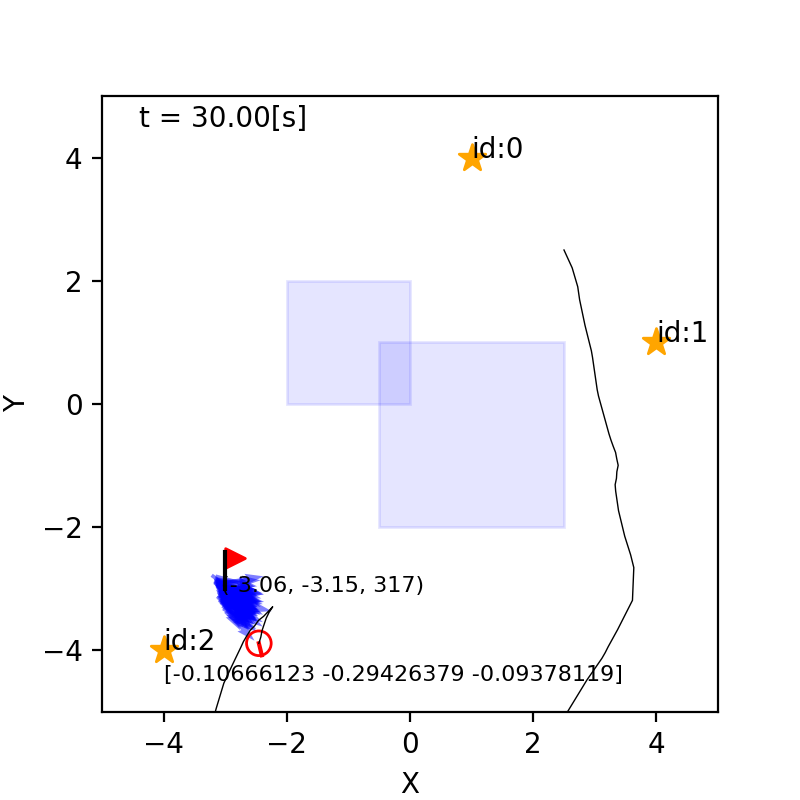

In [41]:
if __name__ == '__main__':  ###qmdp1exec
    time_interval = 0.1
    world = PuddleWorld(30, time_interval, debug=False) 

    ##ランドマークの追加（意地悪な位置に）##
    m = Map()
    m.append_landmark(Landmark(1,4))
    m.append_landmark(Landmark(4,1))
    m.append_landmark(Landmark(-4,-4))
    world.append(m)
    
    ##ゴール・水たまりの追加（これは特に変更なし）##
    goal = Goal(-3,-3)
    puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)] 
    world.append(goal)
    world.append(puddles[0]) 
    world.append(puddles[1])
    
    ##ロボットを作る##
    init_pose = np.array([2.5, 2.5, 0]).T
    pf = Mcl(m, init_pose, 100)
    a = QmdpAgent(time_interval, pf, goal, puddles)
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")

    world.append(r)
        
    world.draw()